# Lambda dark matter extraction program

This program functions as the first part of the project. The goal is to extract the tidal deformability parameter lambda to be used in injections. 

This program extracts the lambda tilde and dark matter mass values from FIG 3 in Nelson et al (2018). They theorize two of three nuclear EOS of NS as a function of total dark matter mass and the tidal deformability parameter lambda. The dark matter is assumed to be bosonic. The three EOS are "soft", "stiff", and "APR", where the "soft" and "stiff" EOS are based on a pressure at a given density, and "APR" is the Akmal-Pandharipande-Ravenhall EOS for NS. "Soft" has a smaller pressure compared to the "APR" EOS and "stiff" has a higher pressure.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy import integrate
from scipy.interpolate import interp1d
from astropy.io import ascii
from astropy.table import Table

# Unpack lambda and dark matter mass values from csv files of each EOS

Values are passed through the interpolation function to match the EOS to then draw samples from 

In [158]:
(soft_Mx, soft_lambda) = np.loadtxt("fig3_soft_data.csv",
                             delimiter = ",", unpack = True)

In [159]:
x_soft = sorted(np.asarray(soft_Mx))
y_soft = sorted(np.asarray(soft_lambda))
soft_lambda_test_interp = interp1d(x_soft, y_soft, bounds_error = False, fill_value = "extrapolate")


In [160]:
(stiff_Mx, stiff_lambda) = np.loadtxt("fig3_stiff_data.csv",
                             delimiter = ',', unpack = True)

In [161]:
x_stiff = sorted(np.asarray(stiff_Mx))
y_stiff = sorted(np.asarray(stiff_lambda))
stiff_lambda_test_interp = interp1d(x_stiff, y_stiff, bounds_error = False, fill_value = "extrapolate")


In [162]:
(apr_Mx, apr_lambda) = np.loadtxt("fig3_APR_data.csv",
                             delimiter = ',', unpack = True)

In [163]:
x_apr = sorted(np.asarray(apr_Mx))
y_apr = sorted(np.asarray(apr_lambda))
apr_lambda_test_interp = interp1d(x_apr, y_apr, bounds_error = False, fill_value = "extrapolate")


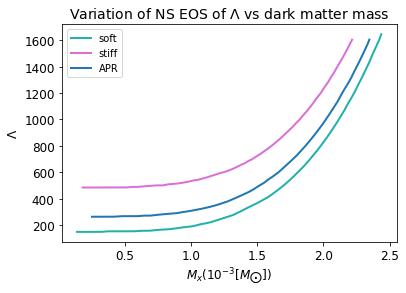

In [252]:
plt.plot(x_soft, y_soft, label = "soft", color = 'lightseagreen', linewidth = 2)
plt.plot(x_stiff, y_stiff, label = "stiff", color = 'orchid', linewidth = 2)
plt.plot(x_apr, y_apr, label = "APR", linewidth = 2)
plt.xlabel(r'$M_{x}(10^{-3}[M_{\bigodot}])$', size = 12)
plt.ylabel(r'$\Lambda$', size = 12)
plt.title(r'Variation of NS EOS of $\Lambda$ vs dark matter mass', size = 14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.legend()
plt.savefig('EOS_lambda_dm.png', bbox_inches = 'tight');

In [165]:
Mx = np.random.uniform(0, 2.5, 1000)

In [166]:
soft_lambda_samples = np.zeros(1000)
stiff_lambda_samples = np.zeros(1000)
apr_lambda_samples = np.zeros(1000)
for i, m in enumerate(Mx):
    soft_lambda_samples[i] = soft_lambda_test_interp(m)
    stiff_lambda_samples[i] = stiff_lambda_test_interp(m)
    apr_lambda_samples[i] = apr_lambda_test_interp(m)

# Generate histograms 

Pass the interpolated functions through histograms to extract lambda values

In [167]:
soft_lambda, soft_bin_edge = np.histogram(soft_lambda_samples, bins=np.logspace(np.log10(min(soft_lambda_samples)),np.log10(max(soft_lambda_samples)), 50), density = True)
stiff_lambda, stiff_bin_edge = np.histogram(stiff_lambda_samples, bins=np.logspace(np.log10(min(stiff_lambda_samples)),np.log10(max(stiff_lambda_samples)), 50), density = True)
apr_lambda, apr_bin_edge = np.histogram(apr_lambda_samples, bins=np.logspace(np.log10(min(apr_lambda_samples)),np.log10(max(apr_lambda_samples)), 50) , density = True)

print(len(soft_lambda), len(stiff_lambda), len(apr_lambda))


49 49 49


In [168]:
mid_soft_bins = [(soft_bin_edge[i] + soft_bin_edge[i+1])/2 for i in range(len(soft_bin_edge)-1)]
mid_stiff_bins = [(stiff_bin_edge[i] + stiff_bin_edge[i+1])/2 for i in range(len(stiff_bin_edge)-1)]
mid_apr_bins = [(apr_bin_edge[i] + apr_bin_edge[i+1])/2 for i in range(len(apr_bin_edge)-1)]

print(len(mid_apr_bins), len(mid_stiff_bins), len(mid_soft_bins))


49 49 49


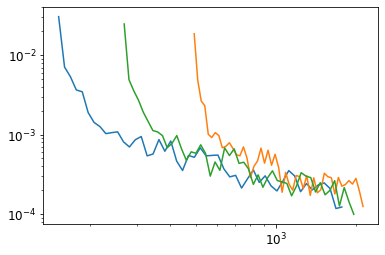

In [275]:
plt.plot(mid_soft_bins, soft_lambda)
plt.plot(mid_stiff_bins, stiff_lambda)
plt.plot(mid_apr_bins, apr_lambda)
plt.xscale('log')
plt.yscale('log')

# create tables for lambda and pdf values from histogram - save as txt file

In [170]:
data = Table()
data['lambda'] = np.array(mid_soft_bins)
data['pdf'] = soft_lambda
data.write('log_lambda_pdf_soft_EOS.txt', format='ascii', overwrite=True)
# ascii.write(data, 'lambda_pdf_soft_EOS.dat', overwrite=True)

In [171]:
data_stiff = Table()
data_stiff['lambda'] = np.array(mid_stiff_bins)
data_stiff['pdf'] = stiff_lambda
data_stiff.write('log_lambda_pdf_stiff_EOS.txt', format='ascii', overwrite=True)
# ascii.write(data, 'lambda_pdf_soft_EOS.dat', overwrite=True)

In [172]:
data_apr = Table()
data_apr['lambda'] = np.array(mid_apr_bins)
data_apr['pdf'] = apr_lambda
data_apr.write('log_lambda_pdf_apr_EOS.txt', format='ascii', overwrite=True)
# ascii.write(data, 'lambda_pdf_soft_EOS.dat', overwrite=True)

# Analytical PDF for lambda

In [173]:
def func_broken_power_law(x_array, p, q, x0, a):
    y_array = np.zeros(len(x_array))
    for i, x in enumerate(x_array):
        if x > x0:
            y_array[i] = a * x**-p
        if x <= x0:
            y_array[i] = a * x**(-q) * x0**(-p + q)
    return y_array

parameters from curve fitting the labda histograms 

In [174]:
# For Soft: {p -> 1.21193, q -> 23.2699, x0 -> 172, a -> 0.955788}
soft_coeff = {'p': 1.21193, 'q':23.2699, 'x0': 172, 'a':0.955788}

# Fro stiff: {p -> 1.67637, q -> 41.1593, x0-> 527, a -> 41.931}
stiff_coeff = {'p': 1.67637, 'q':41.1593, 'x0': 527, 'a':41.931}

# For apr: {p -> 1.42341, q -> 36.7894, x0 -> 290, a -> 4.8688}
apr_coeff = {'p': 1.42341, 'q':36.7894, 'x0': 290, 'a':4.8688}

In [175]:
lambda_array = np.logspace(2, 3.3, 1000)

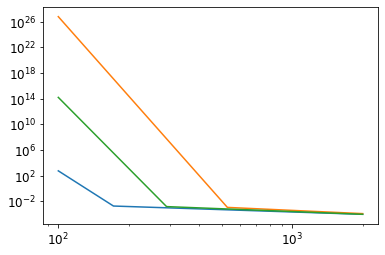

In [176]:
plt.plot(lambda_array, func_broken_power_law(lambda_array, soft_coeff['p'], soft_coeff['q'], soft_coeff['x0'], soft_coeff['a']))
plt.plot(lambda_array, func_broken_power_law(lambda_array, stiff_coeff['p'], stiff_coeff['q'], stiff_coeff['x0'], stiff_coeff['a']))
plt.plot(lambda_array, func_broken_power_law(lambda_array, apr_coeff['p'], apr_coeff['q'], apr_coeff['x0'], apr_coeff['a']))
plt.xscale('log')
plt.yscale('log')

In [177]:
# print(func_broken_power_law(lambda_array, soft_coeff['p'], soft_coeff['q'], soft_coeff['x0'], soft_coeff['a']))

# Soft pdf class for analytical PDF

In [178]:
class soft_pdf(st.rv_continuous):
    def _pdf(self, x_array):
        p = soft_coeff['p']
        q = soft_coeff['q']
        x0 = float(soft_coeff['x0'])
        a = soft_coeff['a']
        
        return func_broken_power_law(x_array, p, q, x0, a)

# sampler

In [179]:
def sampler(dist_class, x_array, num_samples = 100, seed = 853402):
    dist = dist_class()
    cdf = np.array([integrate.simpson(dist.pdf(x_array)[:i], x_array[:i])
                    for i in range(1, len(x_array) + 1)]) / integrate.simpson(dist.pdf(x_array), x_array)
    rngs = [np.random.default_rng(sd) for sd in np.random.default_rng(seed).integers(100000, size = 4)]
    inv_cdf = interp1d(cdf, x_array)
    x_vec = inv_cdf(rngs[1].random(num_samples))
    
    return x_vec

In [180]:
soft_cv = soft_pdf()

In [181]:
soft_x_array = np.logspace(np.log10(soft_lambda_test_interp(0)), np.log10(soft_lambda_test_interp(2.5)), 1000)

In [182]:
lambda_samples_from_soft_pdf = sampler(soft_pdf, soft_x_array, num_samples = 100, seed = 8502)

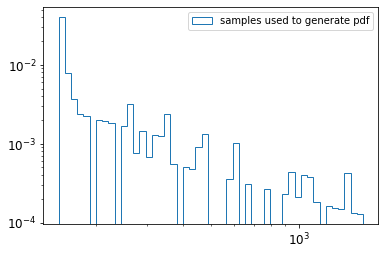

In [183]:
plt.hist(lambda_samples_from_soft_pdf, bins = np.logspace(np.log10(min(lambda_samples_from_soft_pdf)), 
                                                          np.log10(max(lambda_samples_from_soft_pdf)), 50), 
         density = True, histtype = 'step', label = 'samples used to generate pdf')
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [184]:
lambda_samples_from_soft_pdf

array([ 287.78477737,  202.32618158, 1505.82712341,  946.69869932,
        153.31857442,  361.57651558,  322.19239624,  148.56155483,
        354.40483043,  152.56567661,  153.38538353,  231.42348566,
        358.99361487, 1057.86120188, 1106.84324419, 1127.43504595,
        148.41361759, 1564.48152754,  151.10703267,  344.82367178,
        153.94241518,  467.13428407,  159.56820364,  452.51901228,
        163.75515969,  264.15339111,  154.76939475,  214.15095737,
        154.86100171,  149.32698541, 1667.00747878,  618.54716301,
        148.82331596,  334.3521451 ,  151.60628613,  152.79090791,
        157.94936911,  911.33841613,  148.67951732,  182.52349407,
       1292.09002037,  172.50627275,  252.09911279,  152.18301692,
        155.16561127,  169.99788057,  605.7726629 ,  150.204898  ,
       1102.71237271,  275.78063054,  773.91385994,  151.31211444,
        150.939469  ,  177.38024188,  153.0208817 ,  189.40239141,
        168.72778757,  305.28818586,  260.46024166, 1457.14072

In [185]:
data = Table()
data['soft lambda samples'] = np.array(lambda_samples_from_soft_pdf)
# data['pdf'] = soft_lambda
data.write('soft_lambda_pdf_samples.txt', format='ascii', overwrite=True)
# ascii.write(data, 'lambda_pdf_soft_EOS.dat', overwrite=True)

# Stiff pdf class for analytical PDF

In [186]:
class stiff_pdf(st.rv_continuous):
    def _pdf(self, x_array):
        p = stiff_coeff['p']
        q = stiff_coeff['q']
        x0 = float(stiff_coeff['x0'])
        a = stiff_coeff['a']
        
        return func_broken_power_law(x_array, p, q, x0, a)

# Sampler - Stiff

In [187]:
def sampler(dist_class, x_array, num_samples = 100, seed = 853402):
    dist = dist_class()
    cdf = np.array([integrate.simpson(dist.pdf(x_array)[:i], x_array[:i])
                    for i in range(1, len(x_array) + 1)]) / integrate.simpson(dist.pdf(x_array), x_array)
    rngs = [np.random.default_rng(sd) for sd in np.random.default_rng(seed).integers(100000, size = 4)]
    inv_cdf = interp1d(cdf, x_array)
    x_vec = inv_cdf(rngs[1].random(num_samples))
    
    return x_vec

In [188]:
stiff_cv = stiff_pdf()

In [189]:
stiff_x_array = np.logspace(np.log10(stiff_lambda_test_interp(0)), np.log10(stiff_lambda_test_interp(2.3)), 1000)

In [190]:
lambda_samples_from_stiff_pdf = sampler(stiff_pdf, stiff_x_array, num_samples = 100, seed = 8502)

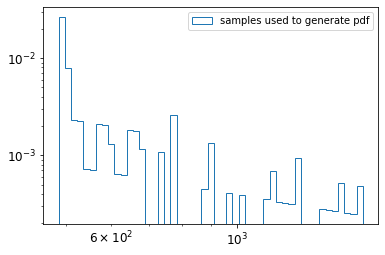

In [191]:
plt.hist(lambda_samples_from_stiff_pdf, bins = np.logspace(np.log10(min(lambda_samples_from_stiff_pdf)), 
                                                          np.log10(max(lambda_samples_from_stiff_pdf)), 50), 
         density = True, histtype = 'step', label = 'samples used to generate pdf')
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [192]:
lambda_samples_from_stiff_pdf

array([ 603.99125379,  515.23870274, 1555.61877886, 1158.6286945 ,
        491.31495613,  678.27142395,  639.38556755,  484.69911027,
        671.30632644,  490.34910794,  491.40013801,  542.34062695,
        675.77062608, 1239.96920728, 1275.31399246, 1290.08127091,
        484.47511925, 1596.04408298,  488.38405527,  661.92558431,
        492.09637922,  775.97112098,  498.01066702,  762.91114957,
        501.10917824,  578.76320315,  493.08897773,  522.98091856,
        493.19403249,  485.83999399, 1666.44821924,  904.79057638,
        485.09067776,  651.56220656,  489.07082629,  490.64103461,
        496.515662  , 1132.38909226,  484.87654298,  507.5385399 ,
       1406.84335972,  504.69539079,  565.56422834,  489.84335054,
        493.55260564,  503.9787376 ,  894.31195725,  487.11587461,
       1272.35468296,  591.27820706, 1028.16425746,  488.66686584,
        488.15196783,  506.02031223,  490.93798428,  509.80998202,
        503.53332628,  622.17869366,  574.74701254, 1521.93039

In [193]:
data = Table()
data['stiff lambda samples'] = np.array(lambda_samples_from_stiff_pdf)
# data['pdf'] = soft_lambda
data.write('stiff_lambda_pdf_samples.txt', format='ascii', overwrite=True)
# ascii.write(data, 'lambda_pdf_soft_EOS.dat', overwrite=True)

# APR pdf class for analytical PDF

In [194]:
class apr_pdf(st.rv_continuous):
    def _pdf(self, x_array):
        p = apr_coeff['p']
        q = apr_coeff['q']
        x0 = float(apr_coeff['x0'])
        a = apr_coeff['a']
        
        return func_broken_power_law(x_array, p, q, x0, a)

# Sampler - APR

In [195]:
def sampler(dist_class, x_array, num_samples = 100, seed = 853402):
    dist = dist_class()
    cdf = np.array([integrate.simpson(dist.pdf(x_array)[:i], x_array[:i])
                    for i in range(1, len(x_array) + 1)]) / integrate.simpson(dist.pdf(x_array), x_array)
    rngs = [np.random.default_rng(sd) for sd in np.random.default_rng(seed).integers(100000, size = 4)]
    inv_cdf = interp1d(cdf, x_array)
    x_vec = inv_cdf(rngs[1].random(num_samples))
    
    return x_vec

In [196]:
apr_cv = apr_pdf()

In [197]:
apr_x_array = np.logspace(np.log10(apr_lambda_test_interp(0)), np.log10(apr_lambda_test_interp(2.4)), 1000)

In [198]:
lambda_samples_from_apr_pdf = sampler(apr_pdf, apr_x_array, num_samples = 100, seed = 8502)

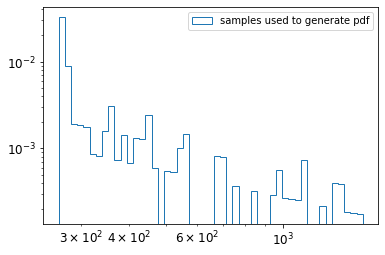

In [199]:
plt.hist(lambda_samples_from_apr_pdf, bins = np.logspace(np.log10(min(lambda_samples_from_apr_pdf)), 
                                                          np.log10(max(lambda_samples_from_apr_pdf)), 50), 
         density = True, histtype = 'step', label = 'samples used to generate pdf')
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [200]:
lambda_samples_from_apr_pdf

array([ 387.12269319,  300.58736441, 1468.89401117,  980.42142641,
        267.64096175,  458.18439048,  420.58150621,  263.02884395,
        451.38622526,  266.94122804,  267.70083418,  330.71798262,
        455.74079221, 1077.1463321 , 1119.77333219, 1137.69496851,
        262.8777272 , 1520.69244026,  265.55041599,  442.27307185,
        268.21104499,  556.26645706,  272.86903769,  542.87832049,
        275.66233282,  363.74463571,  268.95413542,  312.93297999,
        269.03415284,  263.79623768, 1611.63411416,  692.60454431,
        263.28949799,  432.26382524,  266.03246853,  267.15253847,
        271.62964938,  949.63813232,  263.14854989,  283.26475559,
       1281.27248653,  279.45659156,  351.67482026,  266.58071259,
        269.29870438,  278.62559964,  681.2357714 ,  264.66939939,
       1116.190155  ,  375.29089093,  829.62115725,  265.74691219,
        265.3891621 ,  281.10750605,  267.36421602,  287.39412583,
        278.13534191,  404.22143808,  360.05944496, 1425.98949

In [201]:
data = Table()
data['apr lambda samples'] = np.array(lambda_samples_from_apr_pdf)
# data['pdf'] = soft_lambda
data.write('apr_lambda_pdf_samples.txt', format='ascii', overwrite=True)
# ascii.write(data, 'lambda_pdf_soft_EOS.dat', overwrite=True)

# Plots for poster

# soft

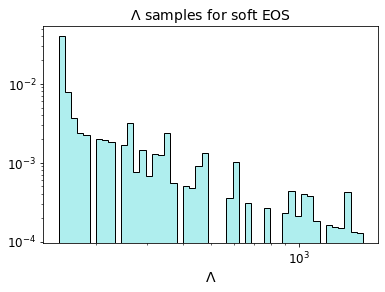

In [253]:
plt.hist(lambda_samples_from_soft_pdf, bins = np.logspace(np.log10(min(lambda_samples_from_soft_pdf)), 
                                                          np.log10(max(lambda_samples_from_soft_pdf)), 50), 
         density = True, histtype = 'step', linewidth = 1, color = 'paleturquoise', fill=True, edgecolor='k')
# plt.xlabel(r'$M_{x}(10^{-3}[M_{\bigodot}])$', size = 12)
plt.xlabel(r'$\Lambda$', size = 14)
plt.title(r'$\Lambda$ samples for soft EOS', size = 14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.yscale('log')
plt.xscale('log')
plt.savefig('soft_lambda_samples.png', bbox_inches = 'tight')
# plt.legend()

# stiff

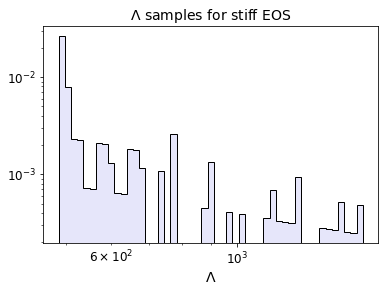

In [254]:
plt.hist(lambda_samples_from_stiff_pdf, bins = np.logspace(np.log10(min(lambda_samples_from_stiff_pdf)), 
                                                          np.log10(max(lambda_samples_from_stiff_pdf)), 50), 
         density = True, histtype = 'step', color = 'lavender', linewidth = 1, fill=True, edgecolor='k')
# plt.xlabel(r'$M_{x}(10^{-3}[M_{\bigodot}])$', size = 12)
plt.xlabel(r'$\Lambda$', size = 14)
plt.title(r'$\Lambda$ samples for stiff EOS', size = 14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.yscale('log')
plt.xscale('log')
plt.savefig('stiff_lambda_samples.png', bbox_inches = 'tight')
# plt.legend()

# APR

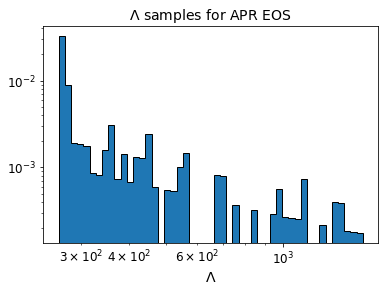

In [304]:
plt.hist(lambda_samples_from_apr_pdf, bins = np.logspace(np.log10(min(lambda_samples_from_apr_pdf)), 
                                                          np.log10(max(lambda_samples_from_apr_pdf)), 50), 
         density = True, histtype = 'step', linewidth = 1, fill=True, edgecolor='k')
plt.xlabel(r'$\Lambda$', size = 14)
plt.title(r'$\Lambda$ samples for APR EOS', size = 14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.yscale('log')
plt.xscale('log')
plt.savefig('apr_lambda_samples.png', bbox_inches = 'tight')
# plt.legend()

# EOS distribution plots

# soft

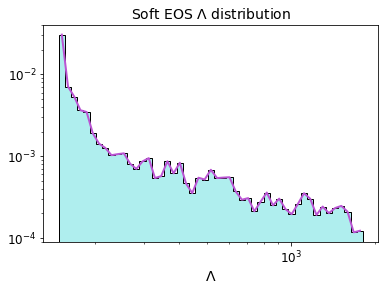

In [308]:
plt.hist(soft_lambda_samples, bins=np.logspace(np.log10(min(soft_lambda_samples)),np.log10(max(soft_lambda_samples)), 50), 
         histtype = 'step', linewidth = 1, color = 'paleturquoise', fill=True, edgecolor='k', density = True)
plt.plot(mid_soft_bins, soft_lambda, color = 'mediumorchid', linewidth = 2)

plt.xlabel(r'$\Lambda$', size = 14)
plt.title(r'Soft EOS $\Lambda$ distribution', size = 14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

plt.xscale('log')
plt.yscale('log')

plt.savefig('soft_EOS_distribution.png', bbox_inches = 'tight');

# stiff

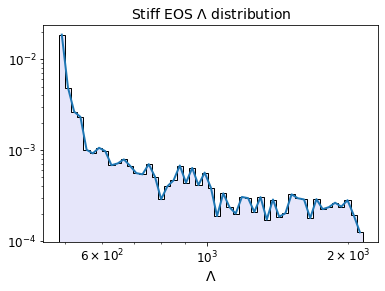

In [309]:
plt.hist(stiff_lambda_samples, bins=np.logspace(np.log10(min(stiff_lambda_samples)),np.log10(max(stiff_lambda_samples)), 50), 
         density = True, histtype = 'step', color = 'lavender', linewidth = 1, fill=True, edgecolor='k')
plt.plot(mid_stiff_bins, stiff_lambda, linewidth = 2)

plt.xlabel(r'$\Lambda$', size = 14)
plt.title(r'Stiff EOS $\Lambda$ distribution', size = 14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

plt.xscale('log')
plt.yscale('log')

plt.savefig('stiff_EOS_distribution.png', bbox_inches = 'tight');

# apr

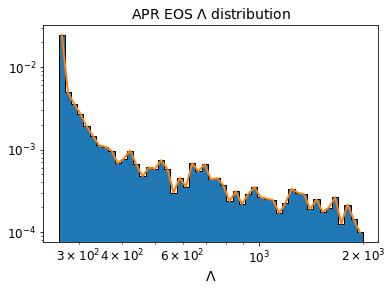

In [310]:
plt.hist(apr_lambda_samples, bins=np.logspace(np.log10(min(apr_lambda_samples)),np.log10(max(apr_lambda_samples)), 50) , 
         density = True, histtype = 'step', linewidth = 1, fill=True, edgecolor='k')
plt.plot(mid_apr_bins, apr_lambda, linewidth = 2)

plt.xlabel(r'$\Lambda$', size = 14)
plt.title(r'APR EOS $\Lambda$ distribution', size = 14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

plt.xscale('log')
plt.yscale('log')

plt.savefig('apr_EOS_distribution.png', bbox_inches = 'tight');